In [1]:
import pandas as pd
import numpy as np
import preproc
from join_data import join_y
pd.set_option('display.max_rows',150)
pd.set_option('display.max_columns',50)


In [2]:
df = pd.read_json('laptops.json')
df = join_y(df, 'laptops_sales.csv')
df = preproc.clean_cols(df)
df = preproc.fill_empty_lists(df)
df = preproc.preprocess_reviews(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rory\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Rory\Desktop\projects\expenditure_prox\preproc.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_preproc'] = df['review_text'].apply(lambda x: __remove_accented_chars(x))
c:\Users\Rory\Desktop\projects\expenditure_prox\preproc.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [ ]:
df

In [55]:
def no_negative_reviews(list_scores):
    """Gets number of negative reviews"""
    no_reviews = 0
    if isinstance(list_scores, list):   
        for item in list_scores:
            item = int(item)
            if item < 3:
                no_reviews += 1

    return no_reviews
 
    
def no_positive_reviews(list_scores):
    """Gets number of positive reviews"""
    no_reviews = 0
    if isinstance(list_scores, list):   
        for item in list_scores:
            item = int(item)
            if item > 3:
                no_reviews += 1

    return no_reviews      

In [56]:
def generate_features(df):
    """Generates some features after prepro"""
    df['neg_reviews'] = df['review_rating'].apply(lambda x: no_negative_reviews(x))
    df['pos_reviews'] = df['review_rating'].apply(lambda x: no_positive_reviews(x))
    df['price/Rvol'] = df['price']/df['no_reviews']
    df['Rvol/%rec'] = df['no_reviews']/df['recommendation_percent']
    df['posR/Rvol'] = df['pos_reviews']/df['no_reviews']
    df['negR/Rvol'] = df['neg_reviews']/df['no_reviews']
    
    return df


In [57]:
df = generate_features(df)

Feature: 0, Score: -24270.19173
Feature: 1, Score: 926.05084
Feature: 2, Score: -44.81509
Feature: 3, Score: -34924.01298
Feature: 4, Score: 349.22367
Feature: 5, Score: 13.11535
Feature: 6, Score: -213.24328
Feature: 7, Score: 60573.09451
Feature: 8, Score: -484.53429
Feature: 9, Score: 118.61089


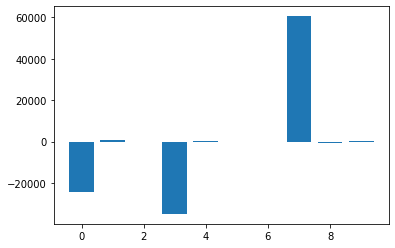

In [122]:
# PUTTING NULLS AS 0 (no reviews)
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
 

# define dataset
X = df[['pos_reviews','neg_reviews', 'price/Rvol', 'Rvol/%rec', 'posR/Rvol', 
        'negR/Rvol','price','no_reviews','recommendation_percent','summary_star_rating','TOTAL_SALES']]

X = X.dropna()
Y=X['TOTAL_SALES']
X = X.drop(['TOTAL_SALES'], axis=1)
Xs = StandardScaler().fit_transform(X)


# define the model
model = LinearRegression()
# fit the model
model.fit(Xs, Y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [83]:
X.columns

Index(['pos_reviews', 'neg_reviews', 'price/Rvol', 'Rvol/%rec', 'posR/Rvol',
       'negR/Rvol', 'price', 'no_reviews', 'recommendation_percent',
       'summary_star_rating'],
      dtype='object')

**This shows that features are in order of importance: no_review, Rvol/%rec, pos_reviews.**

In [185]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = df[['pos_reviews','neg_reviews', 'price/Rvol', 'Rvol/%rec', 'posR/Rvol', 
        'negR/Rvol','price','no_reviews','recommendation_percent','summary_star_rating','TOTAL_SALES','product_name']]

X=X.loc[X.no_reviews !=0]
sales=X['TOTAL_SALES']
names = X['product_name']

In [186]:
X = X.drop(['TOTAL_SALES','product_name'], axis=1)
Xs = StandardScaler().fit_transform(X)
pC = pca.fit_transform(Xs)
df_pc = pd.DataFrame(data = pC, columns = ['c1','c2'])
df_pc.reset_index(drop=True, inplace=True)
sales.reset_index(drop=True, inplace=True)
names.reset_index(drop=True, inplace=True)
fdf = pd.concat([df_pc, sales,names], axis=1, ignore_index=True)

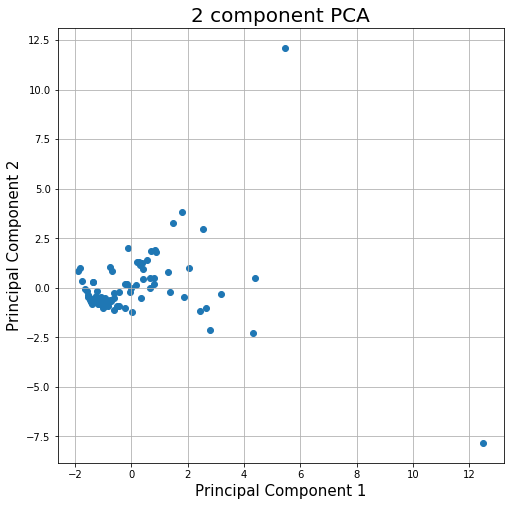

In [187]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(fdf[:][0], fdf[:][1])

ax.grid()

In [189]:
fdf.loc[fdf[:][0]>5]

,0,1,2,3
18,12.503289,-7.831043,18554,hp slim 15.6in i5 8gb 256gb fhd laptop norton 360
63,5.448866,12.113591,256,apple macbook pro touch 2019 16in i7 16gb 512g...


In [192]:
df.loc[(df.product_name=='hp slim 15.6in i5 8gb 256gb fhd laptop norton 360')]

,product_name,price,urls,remotekey,shelf_order,item_category,no_reviews,recommendation_percent,review_date,review_rating,review_text,review_title,summary_star_rating,code,TOTAL_SALES,text_preproc,text_preproc2,pos_reviews,neg_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol
39,hp slim 15.6in i5 8gb 256gb fhd laptop norton 360,539.99,https://www.argos.co.uk/product/5029976?clickP...,5029976,27,[Redefine the laptop experience with 10th Gen ...,544,96,"[2 August 2021, 31 July 2021, 30 July 2021, 30...","[1, 5, 5, 4, 5, 3, 5, 5, 5, 4, 4, 5, 5, 5, 5, ...",[Bought having seen good reviews. Just need a ...,"[Worst laptop I have ever owned, Great, Great ...",4.7,2654329461836246552429230649472743154243885931...,18554,"[[bought, having, seen, good, reviews, just, n...","[[bought, seen, good, review, need, laptop, wo...",521,11,0.992629,5.666667,0.957721,0.020221


In [194]:
df.loc[(df.product_name.str.startswith('apple macbook pro touch 2019 16in i7 16gb 512g'))]

,product_name,price,urls,remotekey,shelf_order,item_category,no_reviews,recommendation_percent,review_date,review_rating,review_text,review_title,summary_star_rating,code,TOTAL_SALES,text_preproc,text_preproc2,pos_reviews,neg_reviews,price/Rvol,Rvol/%rec,posR/Rvol,negR/Rvol
98,apple macbook pro touch 2019 16in i7 16gb 512g...,2399.0,https://www.argos.co.uk/product/1953242?clickP...,1953242,55,[Designed for those who defy limits and change...,2,50,"[28 July 2020, 13 May 2020]","[5, 1]",[Price paid was the lowest I could find so it ...,"[MacBook Pro was the best deal available, Mass...",3.0,6551191647453675436524832534716290356555346838...,256,"[[price, paid, was, the, lowest, i, could, fin...","[[price, paid, lowest, could, find, best, deal...",1,1,1199.5,0.04,0.5,0.5
